---

We reproduce the results and figures from the paper
[[Friz, Gatheral, 2025, Proposition 3.1](https://doi.org/10.1080/14697688.2025.2486173)].

Additional tests are also provided.

---

We compute the Skew-Stickiness Ratio (SSR) using the characteristic function of 
the model.

Let $\varphi_t(T;a) = \mathbb{E}_t[e^{iaX_T}]$ be the characteristic 
function of the log-price $X_T=\log S_T$ at time $t$ for a fixed maturity $T$ 
and real number $a$.

Let $\psi = \log \varphi$. Then, from [[Friz, Gatheral, 2025, Proposition 3.1](https://doi.org/10.1080/14697688.2025.2486173)],
the SSR at time $t$ for maturity $T$ is given by

$$
    \mathcal{R}_t(T) = -
    \frac{\int_{\mathbb{R}^+}
        \frac{da}{a^2 + \frac14}
        \Re \left[
            \rho D_t^\xi \psi_t(T; a-i/2)
            \exp\left(
                \psi_t(T;a-i/2)
            \right)
        \right]
    }{
        \int_{\mathbb{R}^+}
        \frac{a \, da}{a^2 + \frac14}
        \Im \left[
            \exp\left(
                \psi_t(T;a-i/2)
            \right)
        \right]
    }.
$$

In [72]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import utils
import rough_heston
import heston


sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)
SEED = 1234

## The classical Heston SSR

Consider the Heston model:

$$
\begin{aligned}
    dS_t &= S_t \sqrt{V_t} dW_t, \\
    dV_t &= \kappa(\bar{V} - V_t) dt + \eta \sqrt{V_t} dZ_t, \\
    d\langle W, Z \rangle_t &= \rho dt.
\end{aligned}
$$

We compute the SSR in the Heston model using its characteristic function.

In [3]:
params = {
    "v0": 0.4**2,
    "kappa": 0.0,
    "vbar": 0.4**2,
    "eta": 0.6,
    "rho": -0.8,
}

In [ ]:
taus = np.linspace(1e-4, 3, 100)
ssr_values = np.array(
    [heston.ssr_heston_charfunc(tau=tau, params=params) for tau in taus]
)

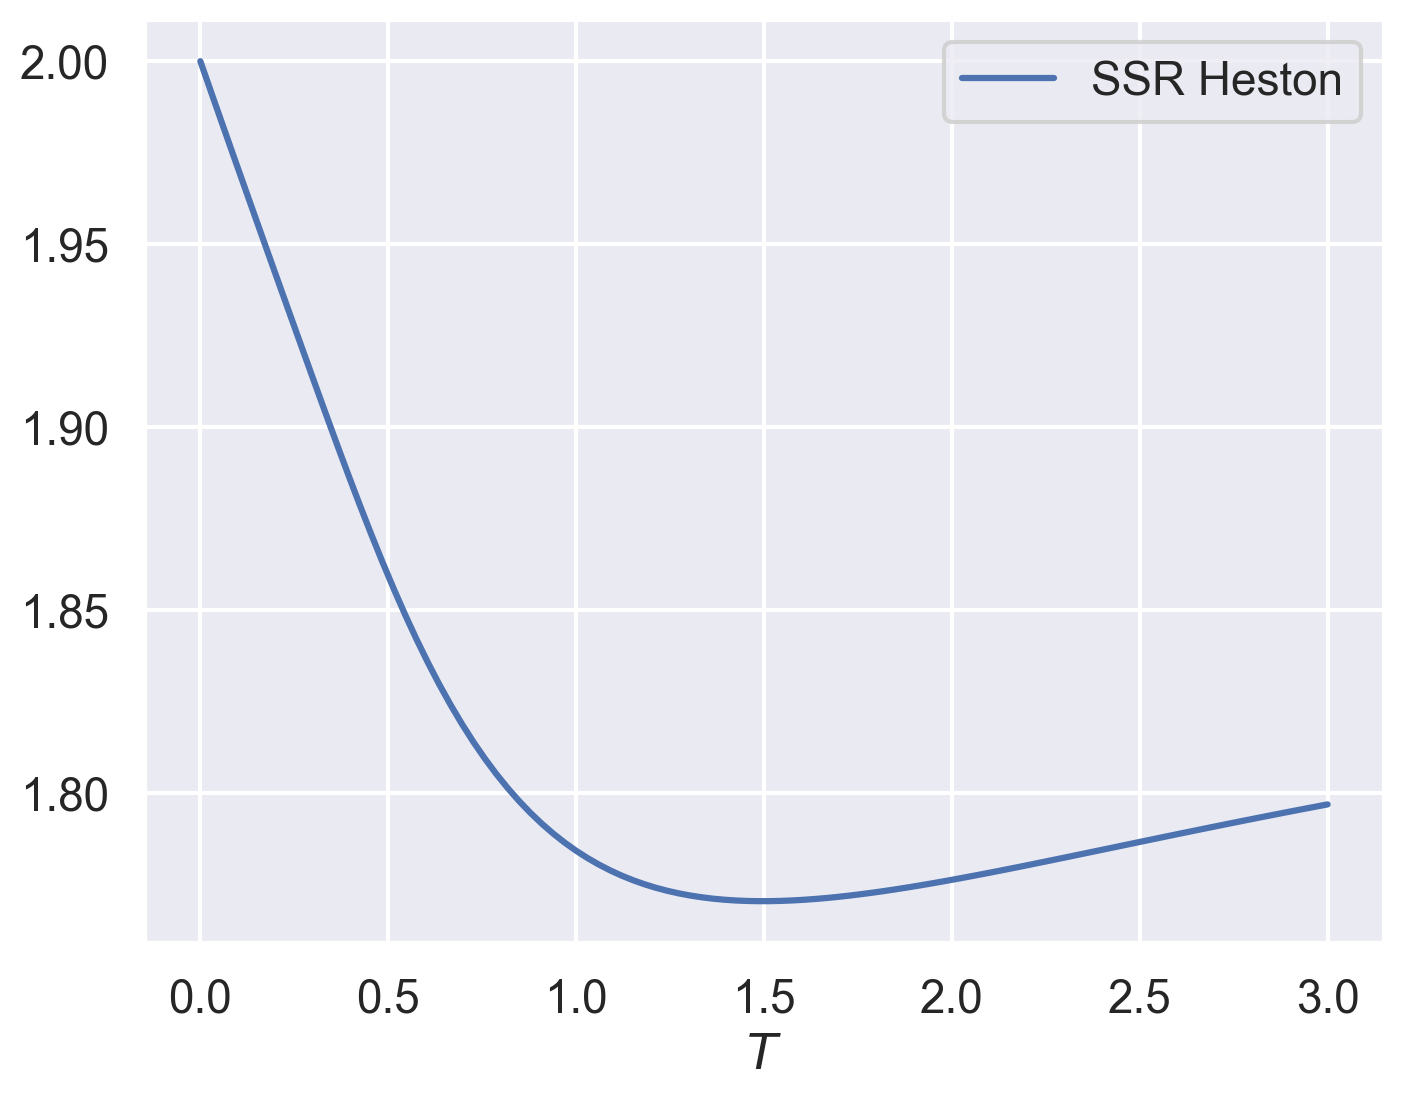

In [35]:
fig, ax = plt.subplots()
ax.plot(taus, ssr_values, label="SSR Heston")
ax.set_xlabel("$T$")
ax.legend()
plt.show()

Testing forest expansion

In [36]:
params = {
    "v0": 0.4**2,
    "kappa": 0.0,
    "vbar": 0.4**2,
    "eta": 0.6,
    "rho": -0.8,
}

In [ ]:
taus = np.linspace(1e-4, 3, 100)

ssr_cf = np.array([heston.ssr_heston_charfunc(tau=tau, params=params) for tau in taus])
ssr_forest = heston.ssr_heston_forest(tau=taus, params=params)

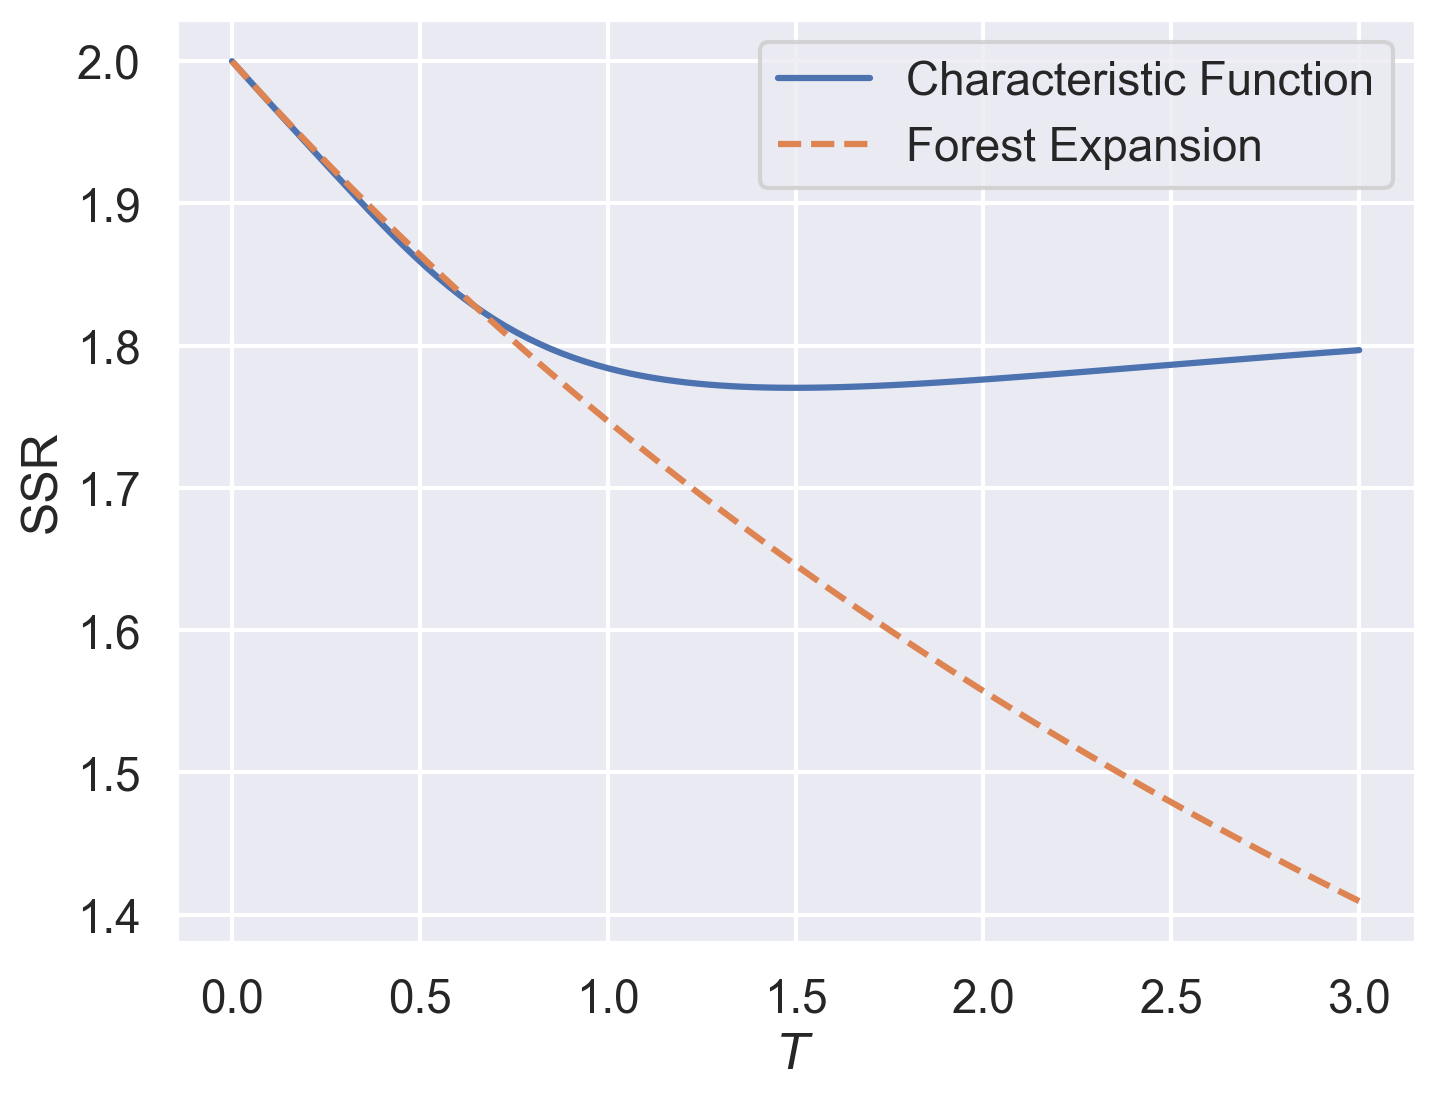

In [38]:
fig, ax = plt.subplots()
ax.plot(taus, ssr_cf, label="Characteristic Function")
ax.plot(taus, ssr_forest, label="Forest Expansion", linestyle="--")
ax.set_xlabel("$T$")
ax.set_ylabel("SSR")
ax.legend()
plt.show()

## The rough Heston SSR

Consider the Heston model:

$$
\begin{aligned}
    dS_t &= S_t \sqrt{V_t} dW_t, \\
    d\xi_t(u) &= \nu (u-t)^{H-1/2} \, E_{H+1/2,H+1/2}\Bigl(-\lambda (u-t)^{H+1/2}\Bigr) \sqrt{\xi_t(t)} dZ_t, \\
    d\langle W, Z \rangle_t &= \rho dt,
\end{aligned}
$$

where $\xi_t(u) = \mathbb{E}_t[V_u]$ and $E_{\alpha,\beta}$ is the Mittag-Leffler function.

We compute the SSR in the Heston model using its characteristic function.

We consider three different shapes for the forward variance curve $\xi_0(t)$:
- Flat: A constant variance over time.
- Contango: A variance curve that increases over time.
- Backwardation: A variance curve that decreases over time.

In [4]:
vbar = 0.025
v0_flat = vbar
v0_contango = 0.005
v0_backwardation = 0.045
rho = -0.8
lbd = 1e-10
nu = 0.4
H = 0.1

params = {"rho": rho, "lbd": lbd, "nu": nu, "H": H}


def xi0(t, shape="flat", lbd_xi0=7.0):
    if shape == "flat":
        return v0_flat + np.zeros_like(t)
    elif shape == "contango":
        return vbar + (v0_contango - vbar) * np.exp(-lbd_xi0 * t)
    elif shape == "backwardation":
        return vbar + (v0_backwardation - vbar) * np.exp(-lbd_xi0 * t)
    else:
        raise ValueError("Unknown shape")

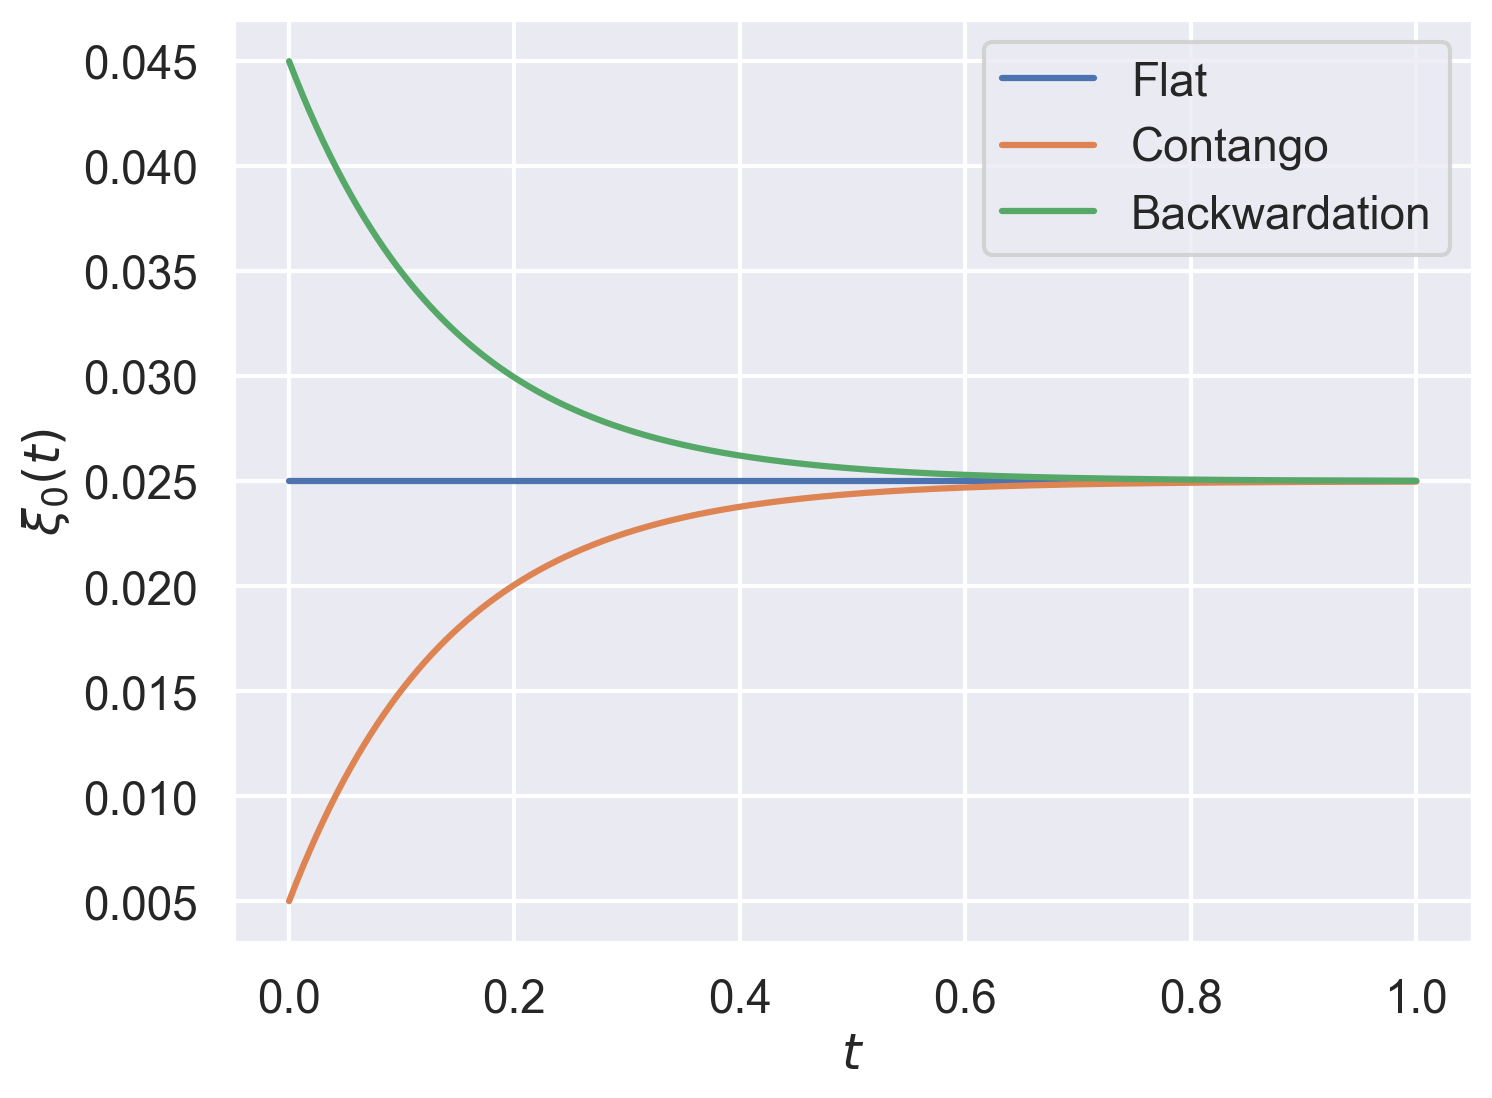

In [5]:
ts = np.linspace(1e-4, 1.0, 1000)

fig, ax = plt.subplots()
ax.plot(ts, xi0(ts, shape="flat"), label="Flat")
ax.plot(ts, xi0(ts, shape="contango"), label="Contango")
ax.plot(ts, xi0(ts, shape="backwardation"), label="Backwardation")
ax.set_xlabel("$t$")
ax.set_ylabel(r"$\xi_0(t)$")
ax.legend()
plt.show()

In [6]:
taus = utils.non_uniform_grid(1e-6, 1.0, 20, power=2.0)
n_pade = 5
n_quad = 50
ssr_values_rheston = {}

for shape in ["flat", "contango", "backwardation"]:
    print(f"shape: {shape}")
    ssr_values_rheston[shape] = rough_heston.ssr_rheston_charfunc(
        tau=taus,
        params=params,
        xi_curve=lambda t, shape=shape: xi0(t, shape=shape),
        n_pade=n_pade,
        n_quad=n_quad,
    )

shape: flat


/Users/florianbourgey/projects/skew-stickiness-ratio/rough_heston.py:119: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  denom = integrate.quad(integrand_denom, 0, np.inf)[0]


shape: contango
shape: backwardation


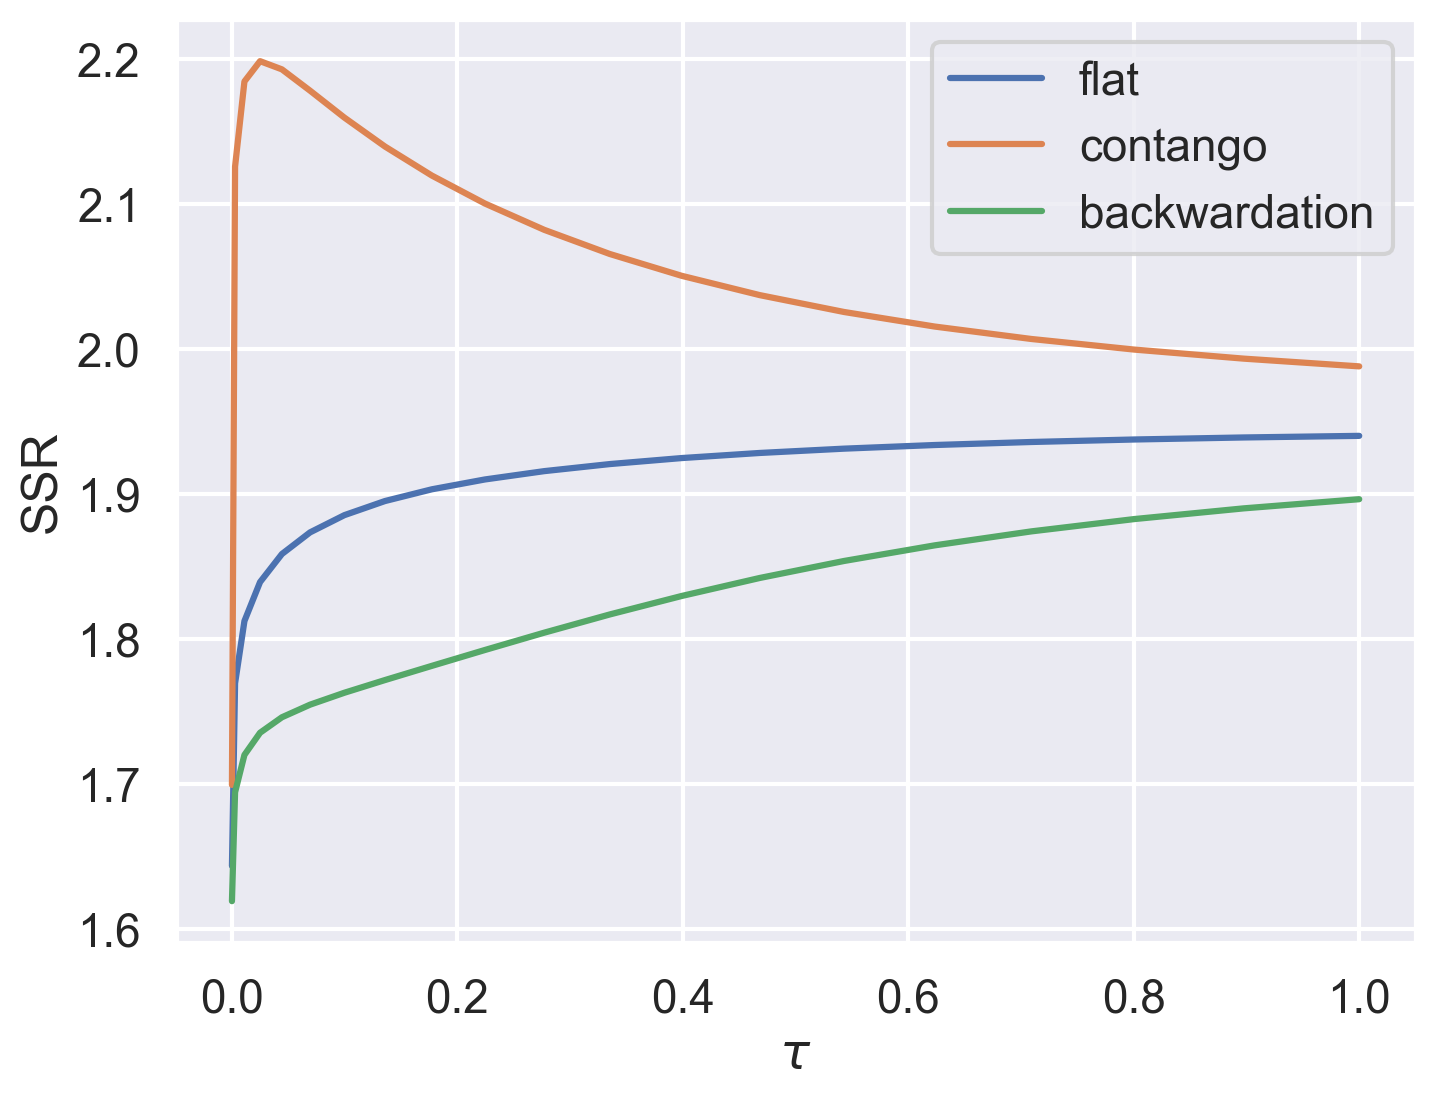

In [7]:
fig, ax = plt.subplots()
for shape, ssr in ssr_values_rheston.items():
    ax.plot(taus, ssr, label=shape)
ax.set_xlabel("$\\tau$")
ax.set_ylabel("SSR")
ax.legend()
plt.show()

SSR with forest expansions and characteristic functions - Figure 1

$H \in \{0.05, 0.1, 0.3, 0.5\}$

In [8]:
xi0_flat = 0.025
params = {"rho": -0.8, "lbd": 0.0, "nu": 0.4}
Hs = [0.05, 0.1, 0.3, 0.5]
n_pade = 5
n_quad = 50

In [9]:
taus_cf = utils.non_uniform_grid(1e-6, 1.0, 20, power=2.0)
ssr_cf_H = {}

for H in Hs:
    print(f"H: {H}")
    params["H"] = H
    ssr_cf_H[H] = rough_heston.ssr_rheston_charfunc(
        tau=taus_cf,
        params=params,
        xi_curve=lambda t: 0.0 * t + xi0_flat,
        n_pade=n_pade,
        n_quad=n_quad,
    )

H: 0.05
H: 0.1
H: 0.3
H: 0.5


/Users/florianbourgey/projects/skew-stickiness-ratio/heston.py:132: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  denom = integrate.quad(denom_integrand, 0, np.inf)[0]


In [10]:
taus_forest = utils.non_uniform_grid(1e-6, 1.0, 200, power=2.0)
ssr_forest_H = {}
for H in Hs:
    print(f"H: {H}")
    params["H"] = H
    ssr_forest_H[H] = rough_heston.ssr_forest_expansion(
        taus_forest, params, xi0_flat=xi0_flat
    )

H: 0.05
H: 0.1
H: 0.3
H: 0.5


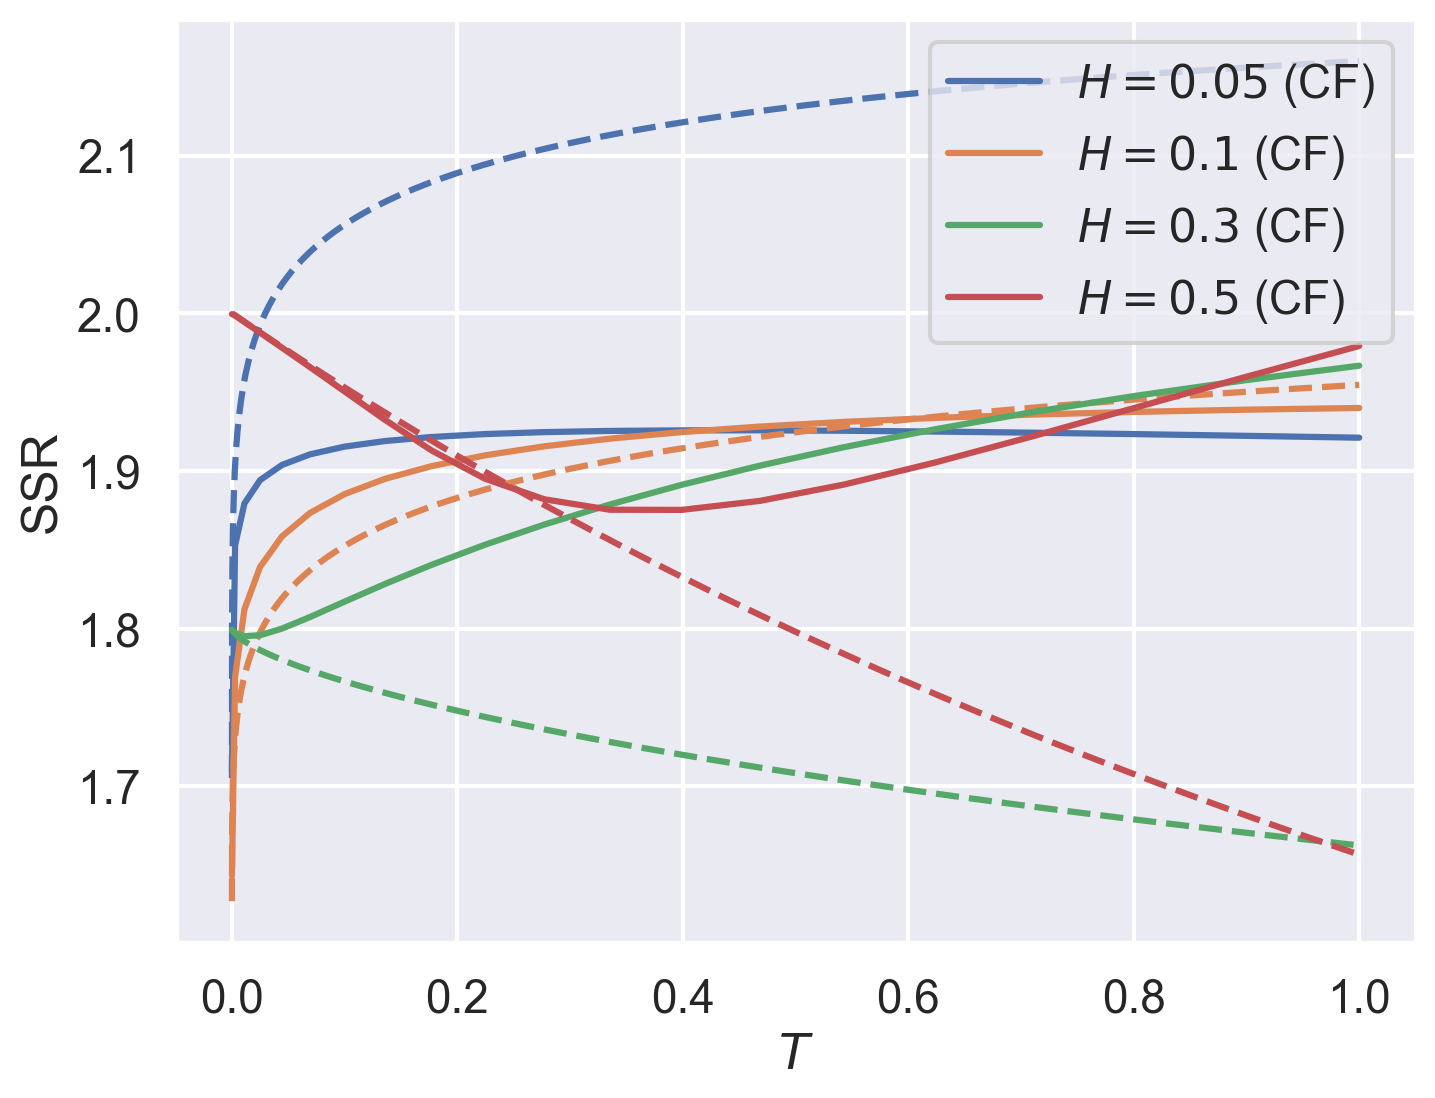

In [11]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots()
for i, H in enumerate(Hs):
    ax.plot(taus_forest, ssr_forest_H[H], linestyle="--", color=colors[i])
    ax.plot(
        taus_cf, ssr_cf_H[H], label=rf"$H={H}$ (CF)", linestyle="-", color=colors[i]
    )
ax.set_xlabel("$T$")
ax.set_ylabel("SSR")
ax.legend()
plt.show()

Sanity check - forest expansion formulas

In [12]:
xi0_flat = 0.025
params = {"rho": -0.8, "lbd": 0.0, "nu": 0.4}
taus = utils.non_uniform_grid(1e-6, 1.0, 200, power=2.0)

for H in np.linspace(0.01, 0.45, 30):
    params["H"] = H
    assert np.allclose(
        rough_heston.ssr_forest_expansion(taus, params, xi0_flat=xi0_flat),
        rough_heston.ssr_forest_expansion(
            taus, params, xi0_flat=xi0_flat, explicit=True
        ),
        rtol=1e-7,
    )

Figure 3 - different sets of parameters

we show that the the smiles are identical but the SSRs are different.

In [13]:
from numfracpy import Mittag_Leffler_two
from scipy.special import gamma

In [64]:
set_1 = {
    "H": 0.1,
    "rho": -0.65,
    # "nu": 0.4,
    "nu": 0.4 / gamma(0.1 + 0.5),
    "lbd": 0.0,
}
set_2 = {
    "H": 0.223,
    "rho": -0.65,
    "nu": 0.481,
    "lbd": 1.0,
}
set_3 = {
    "H": 0.302,
    "rho": -0.65,
    "nu": 0.647,
    "lbd": 2.0,
}


def xi0_flat(t):
    return 0.025 + 0.0 * t

Plots of the rough Heston kernel for the different sets of parameters

In [65]:
def mittag_leffler_two(z, alpha, beta):
    z = np.atleast_1d(np.asarray(z))
    return np.array([Mittag_Leffler_two(z_i, alpha, beta) for z_i in z])


def kernel_rheston(t, H, nu, lbd):
    alpha = H + 0.5
    return nu * t ** (alpha - 1) * mittag_leffler_two(-lbd * t**alpha, alpha, alpha)

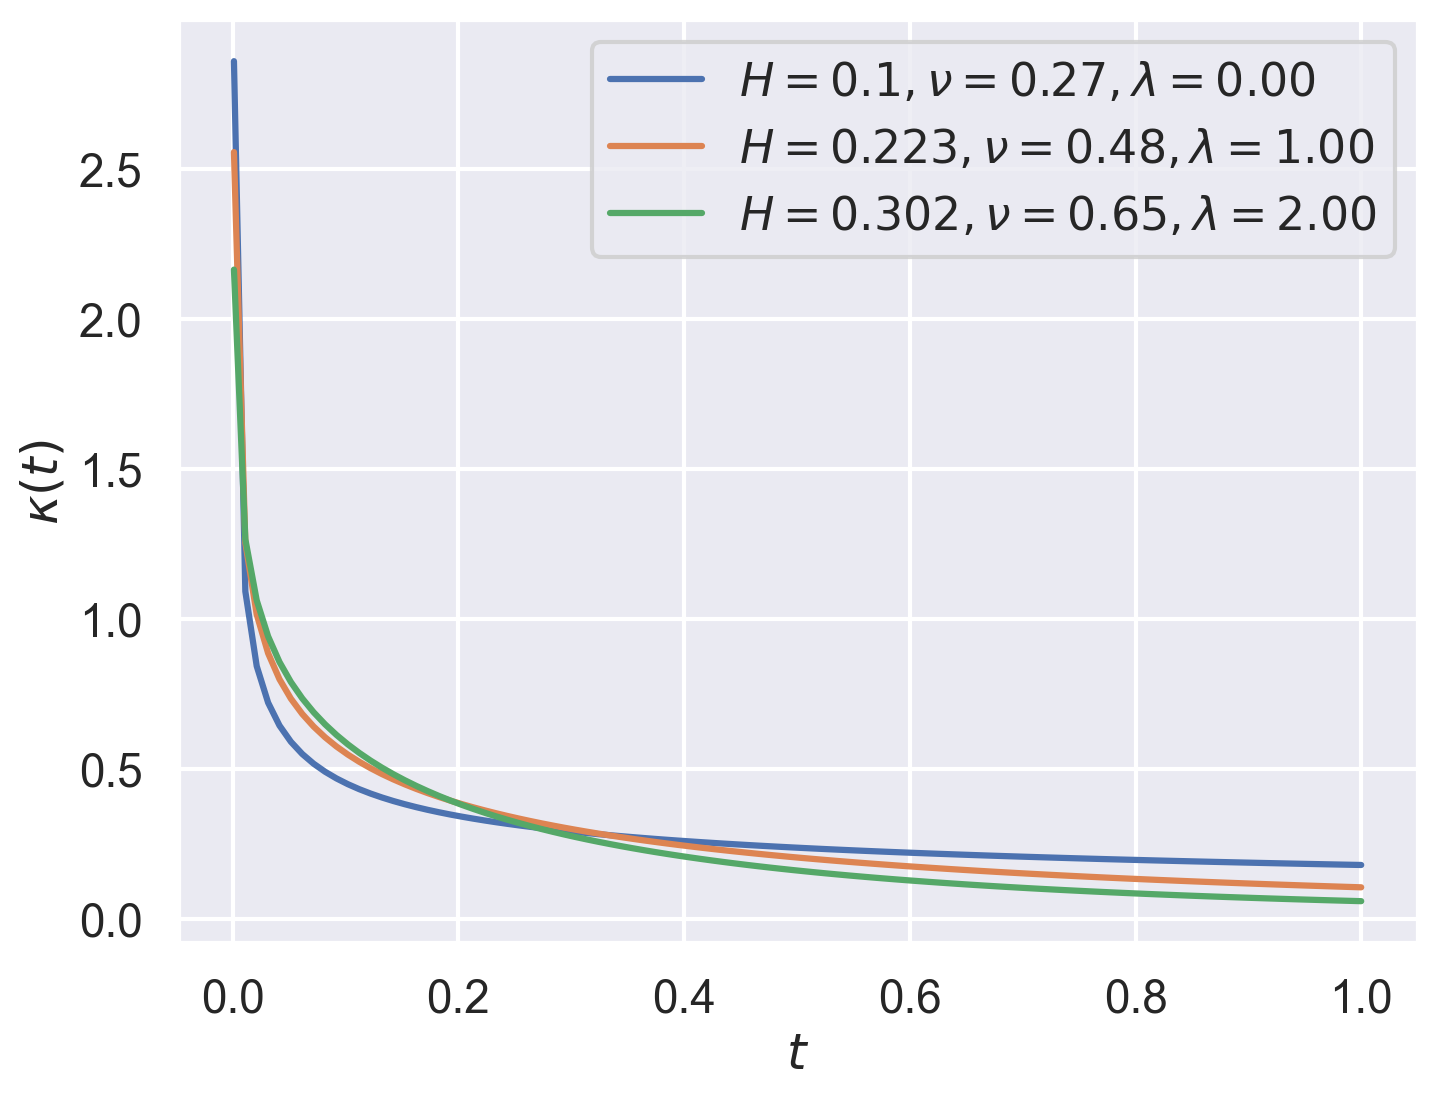

In [66]:
taus = np.linspace(1e-3, 1, 100)

fig, ax = plt.subplots()
for params in [set_1, set_2, set_3]:
    H = params["H"]
    nu = params["nu"]
    lbd = params["lbd"]
    ax.plot(
        taus,
        kernel_rheston(taus, H=H, nu=nu, lbd=lbd),
        label=rf"$H={H}, \nu={nu:<.2f}, \lambda={lbd:<.2f}$",
    )
ax.set_xlabel("$t$")
ax.set_ylabel(r"$\kappa(t)$")
ax.legend()
plt.show()

In [67]:
dict_ks = {
    1 / 12: np.linspace(-0.5, 0.2, 100),
    3 / 12: np.linspace(-0.9, 0.3, 100),
    6 / 12: np.linspace(-1.5, 0.3, 100),
    1: np.linspace(-2.0, 0.6, 100),
}

In [68]:
n_pade = 5
n_quad = 60

In [69]:
smiles_set_1 = np.array(
    [
        rough_heston.impvol_rheston_rational(
            k=ks, tau=mat_i, params=set_1, xi=xi0_flat, n_pade=n_pade, n_quad=n_quad
        )
        for mat_i, ks in dict_ks.items()
    ]
)

In [45]:
smiles_set_2 = np.array(
    [
        rough_heston.impvol_rheston_rational(
            k=ks, tau=mat_i, params=set_2, xi=xi0_flat, n_pade=5, n_quad=100
        )
        for mat_i, ks in dict_ks.items()
    ]
)

In [46]:
smiles_set_3 = np.array(
    [
        rough_heston.impvol_rheston_rational(
            k=ks, tau=mat_i, params=set_3, xi=xi0_flat, n_pade=n_pade, n_quad=n_quad
        )
        for mat_i, ks in dict_ks.items()
    ]
)

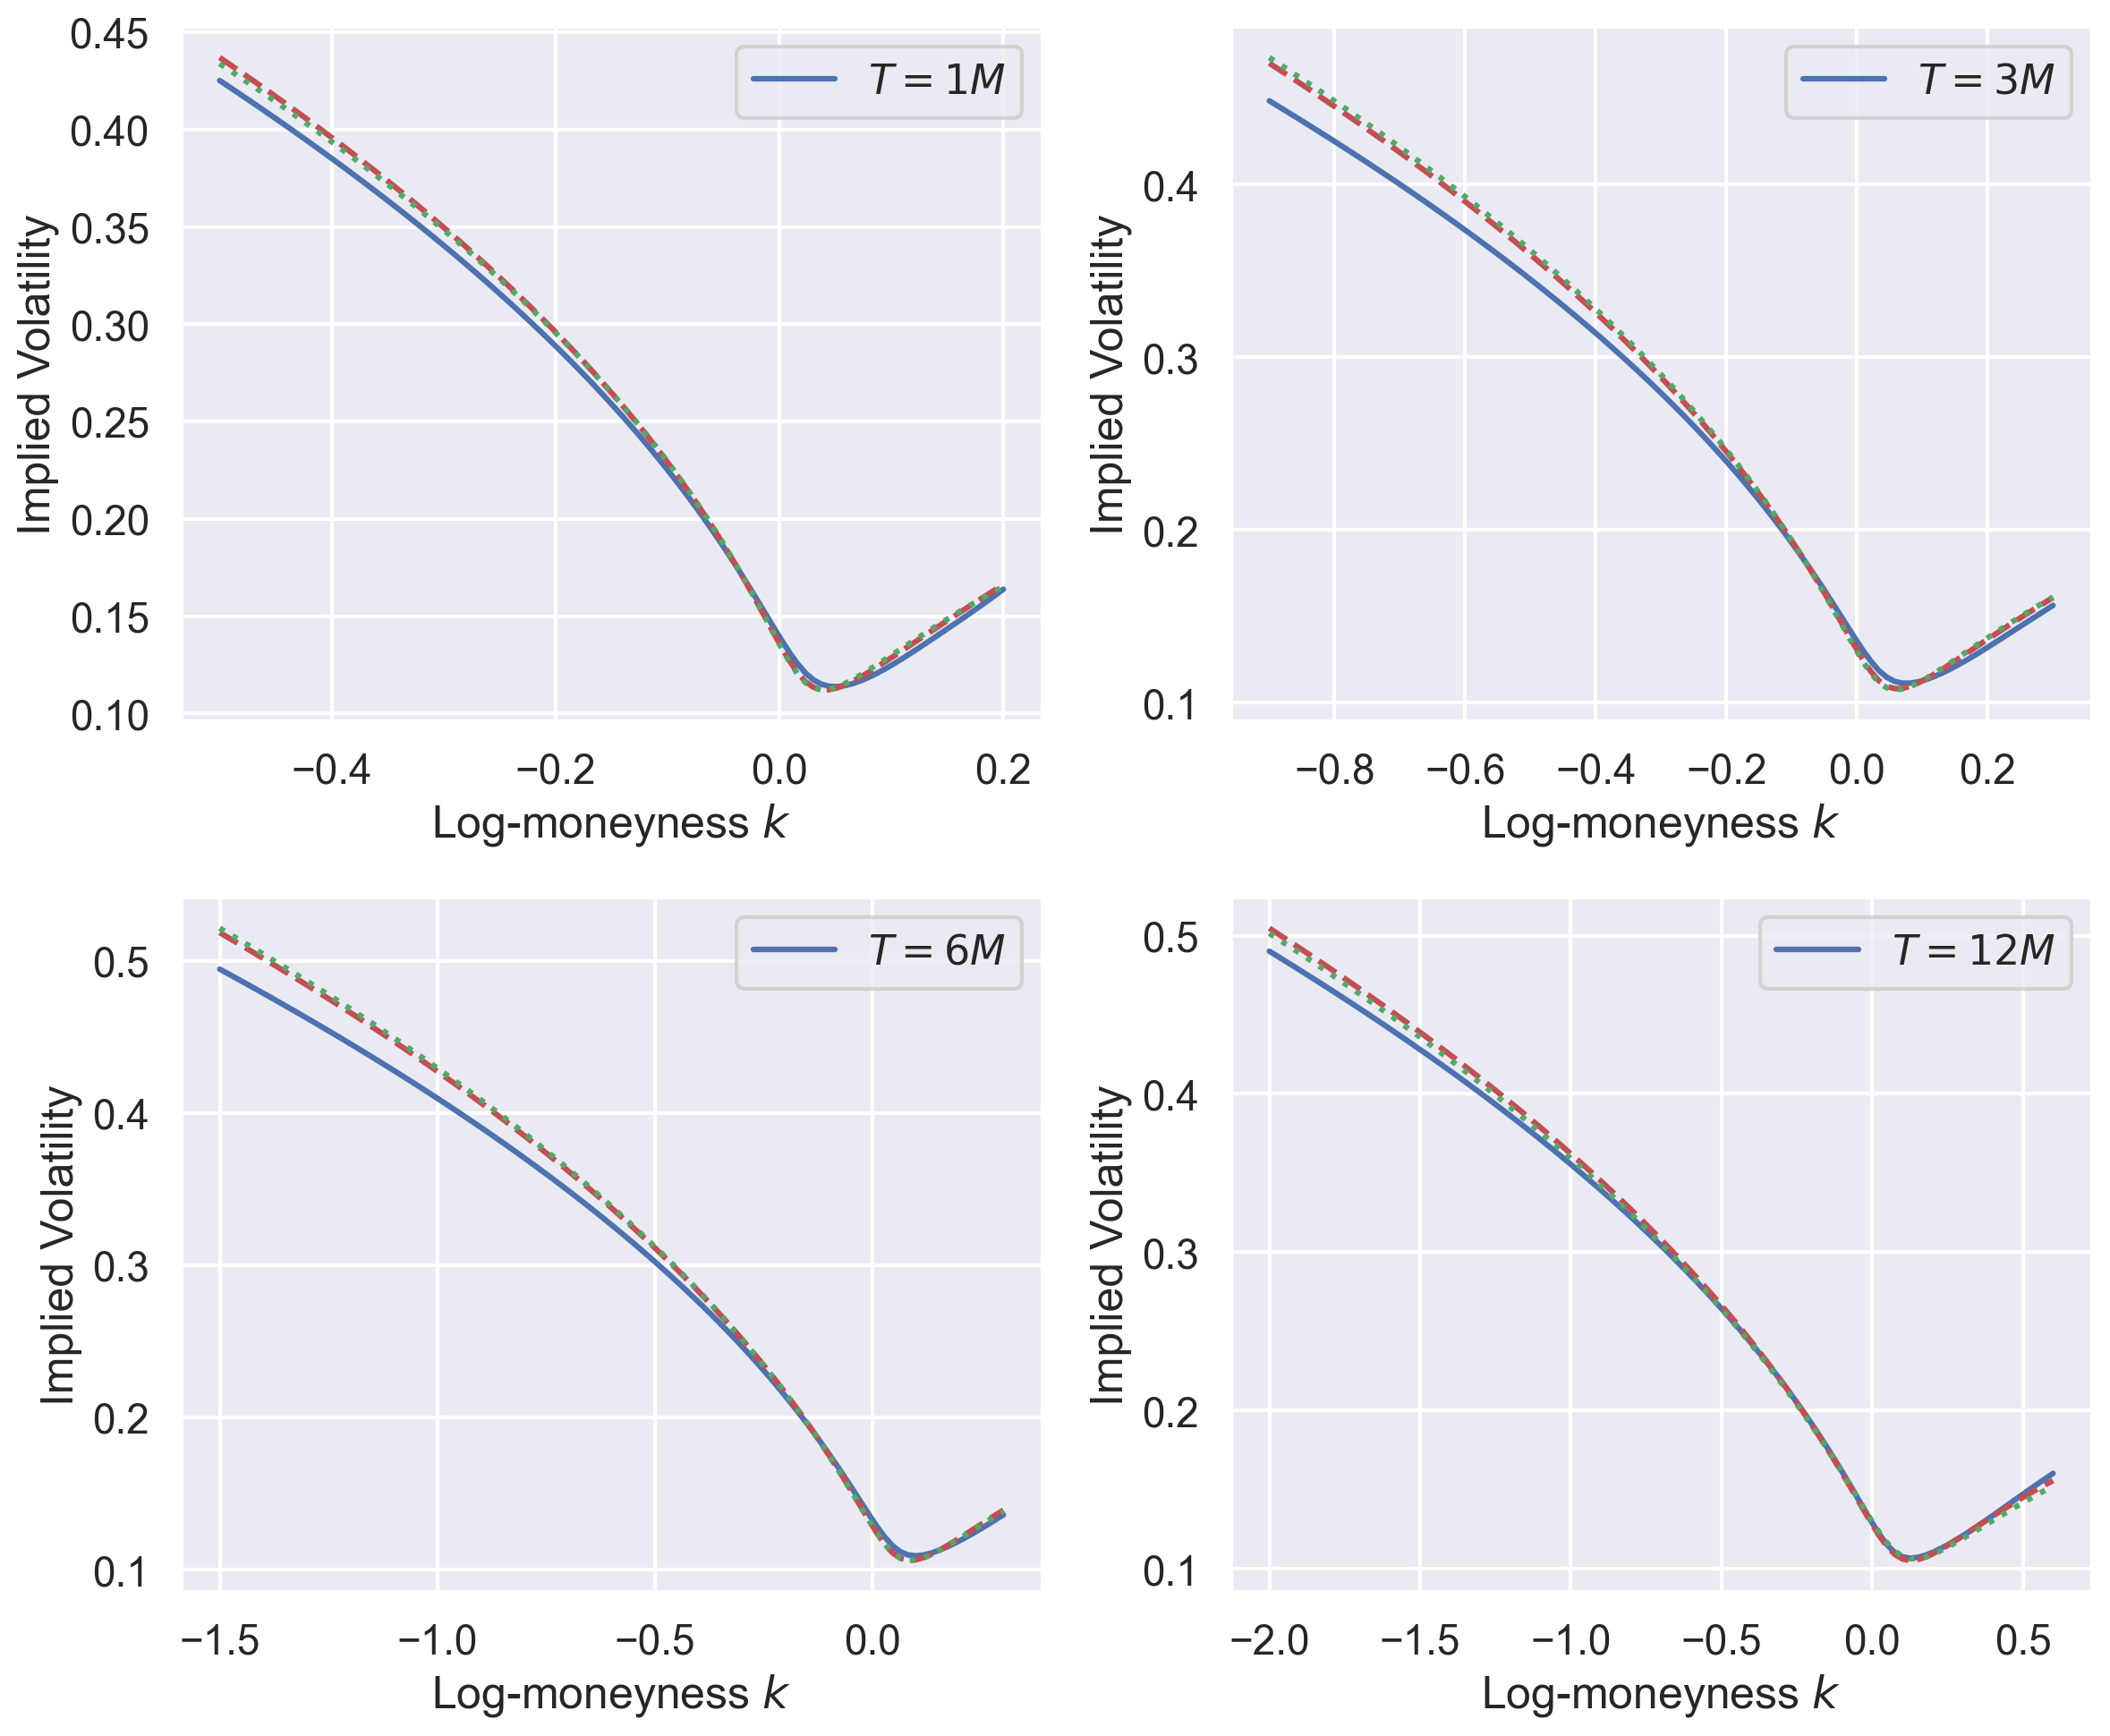

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
for i, (mat_i, ks) in enumerate(dict_ks.items()):
    ax_i = ax[i // 2, i % 2]
    ax_i.plot(ks, smiles_set_1[i, :], "-b", label=rf"$T={mat_i * 12:.0f}M$")
    ax_i.plot(ks, smiles_set_2[i, :], "r--")
    ax_i.plot(ks, smiles_set_3[i, :], "g:")
    ax_i.set_xlabel("Log-moneyness $k$")
    ax_i.set_ylabel("Implied Volatility")
    ax_i.legend()
plt.tight_layout()
plt.show()

Plot associated SSRs

In [70]:
taus_cf = utils.non_uniform_grid(1e-6, 1.0, 20, power=2.0)
ssr_cf = {}
n_pade = n_pade
n_quad = n_quad

for i, set_i in enumerate([set_1, set_2, set_3]):
    ssr_cf[i] = rough_heston.ssr_rheston_charfunc(
        tau=taus_cf,
        params=set_i,
        xi_curve=xi0_flat,
        n_pade=n_pade,
        n_quad=n_quad,
    )

/Users/florianbourgey/projects/skew-stickiness-ratio/rough_heston.py:51: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  n_pade=n_pade,


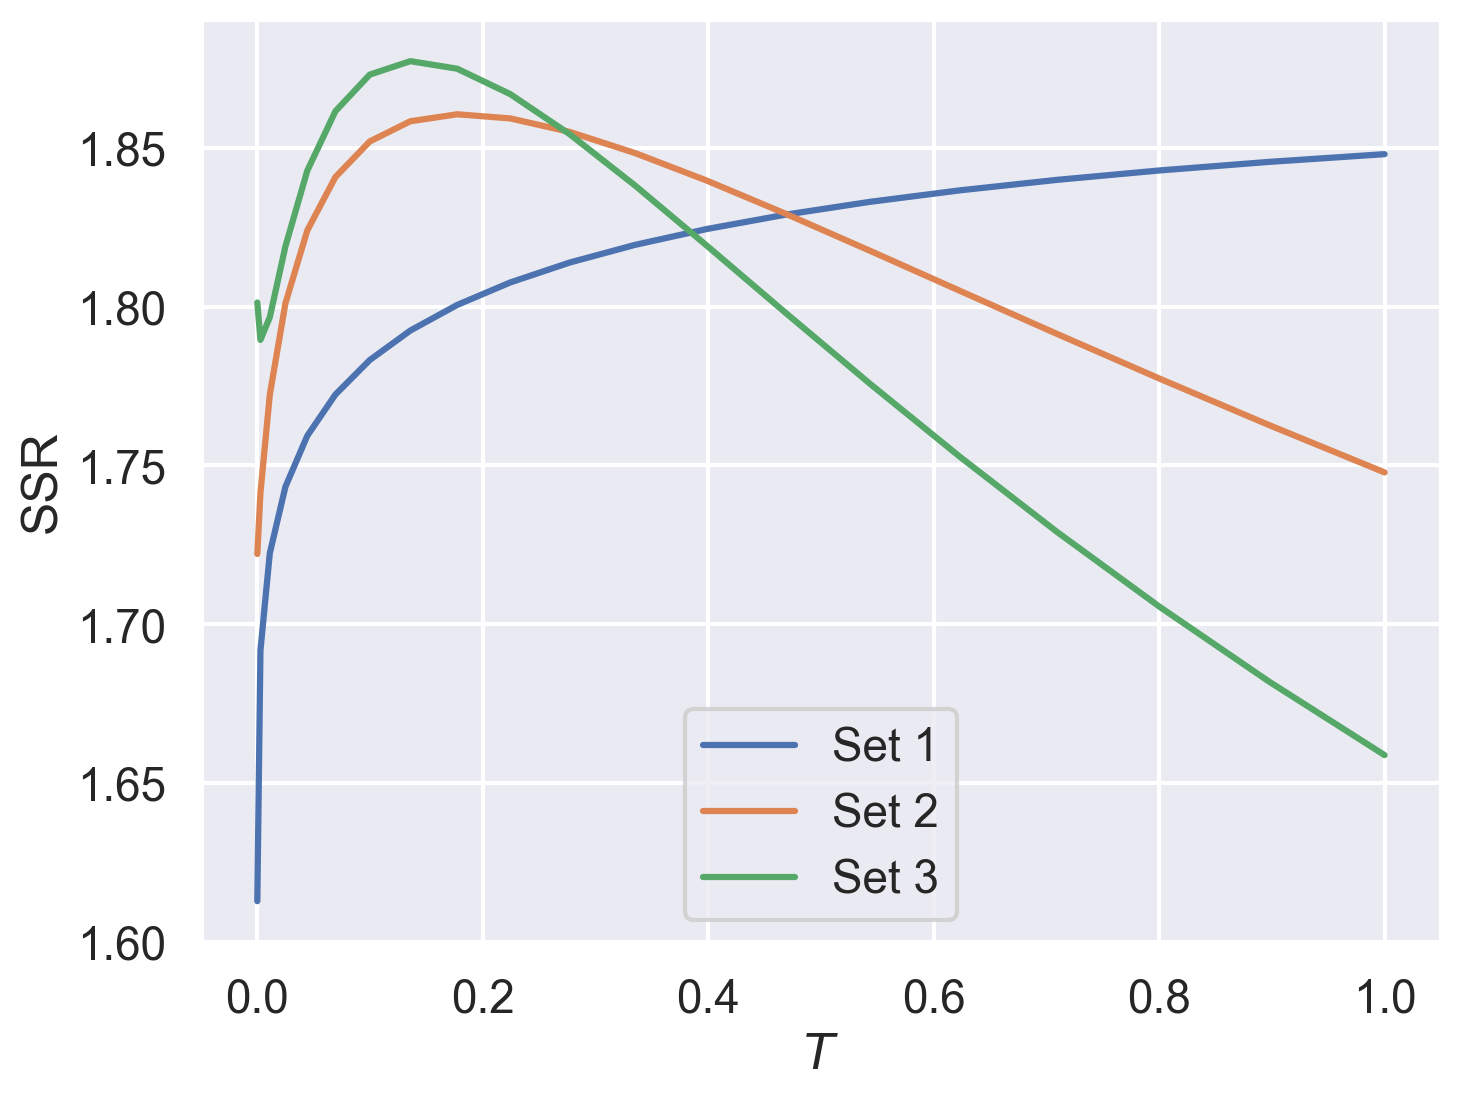

In [74]:
fig, ax = plt.subplots()
for i in range(3):
    ax.plot(taus_cf, ssr_cf[i], label=rf"Set {i + 1}")
ax.set_xlabel("$T$")
ax.set_ylabel("SSR")
ax.legend()
plt.show()